In [1]:
from sage.interfaces.gap import  get_gap_memory_pool_size, set_gap_memory_pool_size
set_gap_memory_pool_size(24364842180)

'''Graded characters in the regular block O_0.
Note: Notation is dominant: L(e) is finite dimensional, Delta(e) is projective, Delta(w0) = L(w0), ...'''


W = WeylGroup("A4", prefix="s")
[s1,s2,s3,s4] = W.simple_reflections()

##################################################################################

n = rank(W)
w0 = W.long_element()
e = W(1)


####### Kazhdan-Lusztig polynomials ##########################

# A faster implementation of KL-polynomials (using the optional package Coxeter 3) is given by this
# Fokko Ducloux’s Coxeter3 C++ library.

# Had to install it: I just typed "sage -i coxeter3" in the terminal.

# It seems that one can direcly coerce from WeylGroup to CoxeterGroup and vice versa.
# I will therefore use CoxeterGroup to calculate KL-polynomials, but for all other Bruhat business I will use WeylGroup.

R.<q> = LaurentPolynomialRing(QQ)

KL = KazhdanLusztigPolynomial(W,q)  # KL-polynomials implemented in standard Sage way
# http://doc.sagemath.org/html/en/reference/combinat/sage/combinat/kazhdan_lusztig.html


CoxeterPackage = CoxeterGroup(W, implementation="coxeter3")

def KLP(x,y):
    '''Returns the KL-polynomial, implemented in "Coxeter3" package by Fokko du Cloux.
    http://math.univ-lyon1.fr/~ducloux/coxeter/coxeter3/english/coxeter3_e.html'''
    
    if x not in W:
        x = convert_from_123(x)
    if y not in W:
        y = convert_from_123(y)
    
    return CoxeterPackage.kazhdan_lusztig_polynomial(CoxeterPackage(x), CoxeterPackage(y))
    # If "coxeter3" is not installed, remove the line 'CoxeterPackage = CoxeterGroup(W, implementation="coxeter3")'
    # and in this function return KL.P(x,y)
    #return KL.P(x,y)

#Point:
#    - standard Sage way: KL.P(x,y)
#    - faster way: KLP(x,y) 


R.<v> = LaurentPolynomialRing(QQ)
def KLPv(x,y):
    '''v-normalization: degree in the polynomial agrees with the graded degree in the Verma module.'''
    return KLP(x, y)(q=1/v^2) * v^(y.length()-x.length())


def mu(w,x):
    '''Returns the KL mu-function with arguments w,x.
    By Humphrey's BGG book p. 175 and p. 169, for w<x we have:
    mu(x,w) = mu(w0*w,w0*x),
    mu(w,x) = dim Exit^1 (L_w,L_x) = dim Exit^1(L_x,L_w) = dim Exit^1(Delta_x,L_w).'''

    if w not in W:
        w = convert_from_123(w)
    if x not in W:
        x = convert_from_123(x)
        
    if w.bruhat_le(x):
        poly_dict = KLP(w,x).dict()       
        j = (x.length()-w.length()-1)/2 
        if j not in poly_dict.keys():
            return 0
        return poly_dict[j]

    return 0


def dimExt(i,y,w):  
    '''Returns dimExt^i(Delta(y),L(w)).'''
    
    y = y*w0                               
    w = w*w0   
    poly_dict = KLP(y,w).dict()       
    j = (w.length()-y.length()-i)/2 
    if j not in poly_dict.keys():
        return 0
    return poly_dict[j]


def mult_Delta_L(y,w):
    '''Returns the Jordan-Holder multiplicity [Delta(y),L(w)] in O_0.
    This is quicker than the analogous operation on GradedChar classes because
    it does not calculate the full Delta.'''
      
    return KLP(y,w)(1)               


def mult_graded_Delta_L(w,k,x):
    '''Returns the graded Jordan-Holder multiplicity [Delta(w) shifted by k,L(x)].
    This is quicker than the analogous operation on GradedChar classes because
    it does not calculate the full Delta.''' 

    l_wx = x.length() - w.length()
    
    i = (l_wx-k)
    if i<0 or i%2!=0:
        return 0
    i = i/2
    
    KL_wx = KLP(w, x).dict()
    if i not in KL_wx.keys():
        return 0
    
    return KL_wx[i]


def earliest_occurence(x):
    '''Returns the smallest non-negative k such that L(x) occurs in Delta(e) at level k.
    To be used later in Lusztig's a function.'''
      
    for k in range(x.length()+1):
        
        if mult_graded_Delta_L(e,k,x) > 0:
            return k
    

##### Parabolic subgroups


def W_(Sigma):
    '''Parabolic subgroup W_Sigma as a list.'''
    
    return W.bruhat_interval(e,w0_(Sigma))


def minimal_rep(x,Sigma):
    '''The minimal representative of the class x*W_Sigma.'''
    
    return x.coset_representative(Sigma, side='right')


def w0_(Sigma):
    '''Returns the longest element of the parabolic subgroup defined by Sigma.
    Format of sigma: e.g. Sigma = [1,2,4] returns s4*s1*s2*s1.'''
    
    return (w0.coset_representative(Sigma, side='right')).inverse() * w0


def Maximal_elements_of_parabolics():
    '''Returns a list of the longest elements of all parabolic subgroups.'''
    
    return [w0_(Sigma) for Sigma in Subsets(range(1,rank(W)+1))]



######### Some operations on graded characters #########


def remove_keys_with_value(dict,value):
    '''Removes all items from dict with given value. Changes the original dict, does not return anything.
    Auxiliary function used in GradedChar().remove_zeros.'''
    
    remove = []
    for x in dict:
        if dict[x] == value:
            remove.append(x)
            
    for x in remove:
        dict.pop(x)

        
def remove_keys_with_value_smaller_than(dict,bound):
    '''Removes all items from dict with value smaller than or equal to "bound".
    Changes the original dict, does not return anything.
    Auxiliary function used in GradedChar().only_positive.'''
    
    remove = []
    for x in dict:
        if dict[x] <= bound:
            remove.append(x)
            
    for x in remove:
        dict.pop(x)

    
def format_star(string):
    '''Windows cannot have * in filenames, so need to use this function when saving files.
    This will replace "*" with "_".'''
    
    new_string = string.replace("*", "_")
    return new_string


def convert_to_123(w):
    '''Converts an element from W to the "123" string notation.
    Does not work with coefficients, as "convert_to_123_long".'''
    
    if w == W(1):
        return "e"
    
    return str(w).replace("s","").replace("*","")


def convert_from_123(string):
    '''Converts one element from W in the "123" string notation to the usual "s1*s2*s3" notation.'''
    
    if type(string)== Integer:
        string = str(string)
        
    if string == "e":
        return W(1)
    
    string = "*".join([char for char in string])
    
    for i in range(1,n+1):
        string = string.replace(str(i),"s%s"%i)
    
    return eval(string)


def convert_to_123_long(string):
    '''E.g. For input "4*s1*s2*s3", the output is "4*123".
    Not used for now.'''
    
    string_e = ""  # This should be a copy of string, but for "e" instead of each "1" that represent the trivial composition factor.
    
    for i in range(len(string)):
        
        condition = 0
        
        if string[i] == "1" and i>0:
            
            if string[i-1] not in ["s","-","0","1","2","3","4","5","6","7","8","9"]:
                
                if i+1==len(string):
                    condition = 1
                
                else:
                    if string[i+1] not in ["*",":","0","1","2","3","4","5","6","7","8","9"]:
                        condition = 1
    
        if condition == 0:
            string_e += string[i]
        
        else:
            string_e += "e"
    
        
    string_no_ast = re.sub(r'(?<=(?<=s).)\*',"",string_e) # Remove "*" if there is "s" two places before.
    string_no_ast_s = string_no_ast.replace("s","")
    
    return string_no_ast_s


class GradedChar:
    '''A class representing a graded character of module in the graded version of category O.
    self.graded is a dictionary where keys are indices of the graded components.
    Each graded component is a dictionary with keys being composition factors in that graded piece, and values are multiplicities.'''
    
    def __init__(self):
        self.component = {}
        self.name = ""
           
    def __str__(self):
        '''Each line becomes graded piece.'''
        
        if self == char_0():   # For zero character, print "0" instead of nothing.
            return "0"
        
        str_glob = ""
        if self.name != "":
            str_glob += self.name +":\n\n"
        
        for i in sorted(self.component.keys()):
            lis_i = []
            
            for w in (self.component[i]).keys():
                
                m = self.component[i][w]    # Multiplicity of w in i-th graded piece of self.
                m_string = ""
                if m != 1:
                    m_string = "%d*"%m      # Needed to print nicelly formated graded pieces.
                
                lis_i += ['%s'%m_string + str(w)]
            
            str_glob += "%d: "%i + ", ".join(lis_i) + "\n"
        
        return str_glob

    def __eq__(self, other): 
        if not isinstance(other, GradedChar):
            # Don't attempt to compare against unrelated types.
            return NotImplemented
        
        self.remove_zeros()      # Remove all the redundancies before comparing.
        other.remove_zeros()
        
        return self.component == other.component

    def __add__(self,char2):    
        char_sum = GradedChar()

        for k in (set(self.component.keys()) | set(char2.component.keys())):    # Union of keys without repeition.

            self_k = self.component.get(k,{})   # ".get" avoids KeyError
            char2_k = char2.component.get(k,{})

            char_sum.component[k] = {}

            for w in (set(self_k.keys()) | set(char2_k.keys())):

                char_sum.component[k][w] = self_k.get(w,0) + char2_k.get(w,0)

        return char_sum
    
    def __mul__(self,other):
        prod = GradedChar()

        for k in self.component:
            prod.component[k] = {}
        
            for w in self.component[k]:
                prod.component[k][w] = other * self.component[k][w]

        return prod
    
    def __rmul__(self,other):
        return self*other
    
    def __sub__(self,other):
        return self+((-1)*other)
    
    def __neg__(self):
        return (-1)*self
    
    
    def rename(self,new_name):
        '''Changes the name of self, and returns new_name.'''
        
        self.name = new_name
        return self.name
    
    
    def remove_zeros(self):
        '''Removes all composition factors with coefficients zero.
        These can occur only when subtracting, i.e. dealing with characters of virtual modules.'''
        
        for k in self.component:
            remove_keys_with_value(self.component[k],0)
        
        remove_keys_with_value(self.component,{})
        
        return self
        
    
    def only_positive(self):
        '''Removes all composition factors with non-positive coefficients.
        These can occur only when subtracting, i.e. dealing with characters of virtual modules.'''
        
        for k in self.component:
            remove_keys_with_value_smaller_than(self.component[k],0)
        
        remove_keys_with_value(self.component,{})
        
        return self    
    
    
    def add_factor(self,i,w):
        '''Adds a composition factor to self in i-th graded piece.'''
        
        if i not in self.component:
            self.component[i] = {}
        
        if w not in self.component[i]:
            self.component[i][w] = 0
        
        self.component[i][w] += 1
        
        self.name = ""    # The character "self" has changed, so the old name is not valid anymore.
        
        return self

    
    def is_simple(self):
        '''Checks whether self is a simple module.'''

        self.remove_zeros()

        if len(components(self)) != 1:
            return False

        only_component = self.component[ list(self.component.keys())[0] ]

        if len(only_component.keys()) != 1:
            return False

        only_factor = list(only_component.keys())[0]

        if only_component[ only_factor ]  != 1:
            return False

        return True
   
    
    def is_true_character(self):
        '''Returns True iff all the coefficients of self are non-negative.
        Assumes that all the coeffictients are integers.'''
        
        for i in self.component:
            for w in self.component[i]:
                if not ( self.component[i][w] >= 0 ):
                    return False
        return True
  

    def min_character(self,char2):
        '''Returns the character whose components have multiplicities equal to minimum
        of the multiplicities of the corresponding components in self and char2.'''
        
        char_min = GradedChar()
       
        for k in (set(self.component.keys()) | set(char2.component.keys())):    # Union of keys without repeition.

            self_k = self.component.get(k,{})   # ".get" avoids KeyError
            char2_k = char2.component.get(k,{})

            char_min.component[k] = {}

            for w in (set(self_k.keys()) | set(char2_k.keys())):

                char_min.component[k][w] = min(self_k.get(w,0),char2_k.get(w,0))

        return char_min    
    

    
######### Some operations on graded characters #########


def shift(char,i):
    '''Returns the shift by i of char.'''
    
    char_new = GradedChar()
    
    for key in char.component.keys():
        char_new.component[key-i] = char.component[key]
    
    return char_new


def dual(char):
    '''Returns the graded dual of char.
    Input: GradedChar.'''
    
    char_dual = GradedChar()
    
    for key in char.component.keys():
       char_dual.component[-key] = char.component[key]
    
    return char_dual


def components(char):
    '''Returns the list of indexes of non-zero graded pieces of char.'''
    
    char.remove_zeros()
    return sorted(char.component.keys())


def truncate(char,lis):
    '''Cuts off from char all graded pieces from lis.'''
    
    for k in lis:
        char.component.pop(k, None)
    
    return char
    
    
def mult(char,i,w):
    '''Returns the multiplicity of w in i-th graded piece of char.'''
    
    if i not in char.component:
        return 0
    
    return char.component[i].get(w,0)


def total_mult(char,w):
    '''Returns the total multiplicity of w in char.'''
    
    return sum(char.component[i].get(w,0) for i in char.component)


def dict_mult(char,w):
    '''Returns dictionary with items (k:m), where m is the multiplicity of w in k-th graded piece of char.'''
    
    dic = {}
    for k in char.component:
        if char.component[k].get(w,0) != 0:
            dic[k] = char.component[k][w]
            
    return dic


def clean(char):
    '''Returns cleaner output: simple reflections are denoted by 1,2,3, ...'''
    
    char_dummy = GradedChar()
    
    char_dummy.name = (char.name).replace("(1)","(e)").replace("s","").replace("*","")
    
    for k in char.component:
        char_dummy.component[k] = {}
        
        for w in char.component[k]:
            char_dummy.component[k][convert_to_123(w)] = char.component[k][w]
    
    return(str(char_dummy))


def print_clean(char):
    '''Prints cleaner output: simple reflections are denoted by 1,2,3, ...'''
    
    print(clean(char))
    

def combinatorial_cokernel(char1, char2):
    '''Returns the lower bound on the cokernel of a map from X to Y.'''
    
    virtual = char2-char1
    virtual.only_positive()
    
    return virtual


def combinatorial_kernel(char1, char2):
    '''Returns the lower bound on the kernel of a map from X to Y.'''
    
    virtual = char1-char2
    virtual.only_positive()
    
    return virtual



def ungrade(X):
    '''Returns the ungraded version of graded character X: all composition factors are moved to degree 0.'''
    
    unX = char_0()
    
    for i in components(X):
        unX += shift(X,i)
    
    truncate(unX,[i for i in components(unX) if i != 0])
    
    return unX



######### Some graded characters #########


def char_0():
    '''Returns the zero graded character.'''
    
    zero = GradedChar()
    zero.rename('0')
    return zero


def char_L(w):
    '''Returns the graded character of the simple L(w).'''
    
    L = GradedChar()
    L.add_factor(0,w)
    L.rename('L(%s)'%w)
    return L

        
def char_Delta(w):
    '''Returns the graded character of the Verma Delta(w).
    Reference: Humphrey's BGG book, Thm p. 175.'''
        
    Delta = GradedChar()
    
    const_name = 'Delta(%s)'%w
    const_dict = is_saved(const_name, option1="read_it")      # Here we check if it already exists in a file.
    
    if const_dict != None:
        Delta.component = const_dict
        Delta.rename(const_name)
        return Delta
    
    for x in W.bruhat_interval(w,w0):

        l_wx = x.length() - w.length()
        KL_wx = KLP(w, x).dict()
        for i in KL_wx.keys():
            for j in range(KL_wx[i]):
                Delta.add_factor(l_wx-2*i, x)

    Delta.rename(const_name)    
    return Delta
     

def char_Nabla(w):
    '''Returns the graded character of the dual Verma Nabla(w).'''
    
    Nabla = dual(char_Delta(w))
    Nabla.rename('Nabla(%s)'%w)
    return Nabla
    

def char_P(w):
    '''Returns the graded character of the indecomposable projective P(w).
    Uses graded BGG reciprocity.'''
    
    P = GradedChar()

    const_name = 'P(%s)'%w
    const_dict = is_saved(const_name, option1="read_it")      # Here we check if it already exists in a file.
    
    if const_dict != None:
        P.component = const_dict
        P.rename(const_name)
        return P
    
    for x in W.bruhat_interval(e,w):
        
        Delta = char_Delta(x)
        
        dic = dict_mult(Delta,w)
        
        for k in dic:
            P += shift(Delta,-k)*dic[k]

    P.rename('P(%s)'%w)
    return P
        
    
def char_I(w):
    '''Returns the graded character of the indecomposable injective I(w).'''
    
    I = dual(char_P(w))     
    I.rename('I(%s)'%w)
    
    return I
        

def char_T(w):
    '''Returns the graded character of the indecomposable tilting module T(w).
    Uses (graded) Soergel reciprocity.
    See Humphrey's BGG book, p. 233.
    This can also be proved by applying translation to graded BGG reciprocity.'''
    
    T = GradedChar()
    
    const_name = 'T(%s)'%w
    const_dict = is_saved(const_name, option1="read_it")      # Here we check if it already exists in a file.
    
    if const_dict != None:
        T.component = const_dict
        T.rename(const_name)
        return T
    
    for x in W.bruhat_interval(w,w0):
        dict = dict_mult(char_Delta(w0*x),w0*w)
        
        for k in dict:
            T += shift(char_Delta(x),k)*dict[k]
    
    T.rename('T(%s)'%w)
    return T    
    

def graded_char_BGG(w):
    '''Returns the graded character of the BGG complex of L(w).'''
    
    sum = char_0()
    l_w = w.length()
    
    for x in W.bruhat_interval(w,w0):
        l_x = x.length()
        
        sum += ((-1)^(l_x-l_w))*shift(char_Delta(x),-l_x+l_w)
        
    return sum



################ Projective functors ################


def theta_simple_simple(s,y):        
    '''Returns the graded character of theta_s(L_y), where s is a simple reflection,
    and y an element from W (not of class GradedChar).
    Reference: Coulembier-Mazorchuk-Zhang, Proposition 16,
    plus the fact that y and z are comparable if z appears.'''
        
    result = GradedChar()
    
    if y.bruhat_le(y*s):
        return result
    
    result.add_factor(-1,y)
    result.add_factor(1,y)
    result.add_factor(0,y*s)
    
    for z in W.bruhat_interval(y,w0):
        
        if z.bruhat_le(z*s):
            m = mu(y,z)
            if m != 0:
                result += m*char_L(z)
    
    return result


def theta_simple(s,M):
    '''Returns the graded character of theta_s(M), where s is a simple reflection,
    and M is from class GradedChar.
    Uses the function "theta_simple_simple" and the fact that theta is exact functor.'''
        
    result = GradedChar()
    
    for k in M.component:
        for w in M.component[k]:
            result += shift(M.component[k][w] * theta_simple_simple(s,w),  -k)
    
    return result


def theta(ws, char):          
    '''Returns the graded character of theta_ws(char).
    Uses recursion from [Mazorchuk: Some homolgical properties ... I, the proof of Theorem 11.a)].'''
    
    result = GradedChar()
    
    if char.name != "":
        const_name = 'theta_%s(%s)'%(ws,char.name)
        const_dict = is_saved(const_name, option1="read_it")      # Here we check if it already exists in a file.

        if const_dict != None:
            
            result.component = const_dict
            result.rename(const_name)

            return result
    
    factors = ws.reduced_word()
    
    if len(factors) == 0:    # theta_e = Identity
        return char
    
    if char == char_L(w0):   # theta_x(L(w0)) = T(w0*x)
        result = char_T(w0*ws)
        result.rename(const_name)
        return result
    
    s = W.simple_reflections()[factors[len(factors)-1]]
    
    if len(factors) == 1:    # basis of the recursion
        
        result = theta_simple(s,char)
        
        if char.name != "":
            result.rename(const_name)
        return result
    
    w = ws * s
        
    subtract = [ y for y in W.bruhat_interval(e,w) if (y*s).bruhat_le(y) and mu(y,w) !=0  ]
    
    result = theta_simple(s, theta(w,char))
    
    for y in subtract:
        result = result - mu(y,w)*theta(y,char)
    
    if char.name != "":
        result.rename(result.rename(const_name))
    return result


def M(x,y):
    '''Different notation for theta_x(L(y)).'''
    
    return theta(x,char_L(y))


def th(a,b):
    '''Same as theta, but uses 123-notation in number format, not as strings.
    Also prints theta along the way.'''
    
    x = convert_from_123(str(a))
    y = convert_from_123(str(b))
    
    X = theta(x,char_L(y))
    print_clean(X)

    return  X



######### Saving and reading characters to/from external files #########


import os
import datetime
import re    # Regular expressions!

    
def save_(char):
    '''Saves char to a file in the folder.
    In fact, it saves 
    1. "char.component" dictionary to "./Graded_characters_in_O_0_data/Modules/'type'/", under the name "dict_'name'.txt",
    2. The output of print(char) string to "./Graded_characters_in_O_0_data/For_human/'type'/", under the name "'name'.txt".
    3. The output of print_clean(char) string to "./Graded_characters_in_O_0_data/For_human123/'type'/".
    Asterixes (*) are omitted from filenames.'''

    if char.name == "":
        return "Error: char has no name."        # For now I do not want to save characters without a name.
    
    CT = CartanType(W)[0]+str(CartanType(W)[1])
    
    folder1 = 'Graded_characters_in_O_0_data'
    For_computer = 'Modules'    
    path_computer = folder1 +'/' + For_computer     
    path_computer_CT = path_computer + '/' + CT
    
    for path in [folder1, path_computer, path_computer_CT]: # Check if necessary folders exist, and create them if not.

        if not os.path.isdir(path):  # Is there a folder already?
            os.mkdir(path)        # If not, create one.
    
    name_without_asterix = format_star(char.name)     # remove asterixes from name

    file_computer = open(path_computer_CT + "/dict_%s.txt"%name_without_asterix, "w+")        
    file_computer.write(str(char.component))     # Saves as a dictionary - usefull if I want to load back.    
    file_computer.close()  
    

def is_saved(name, option1):    # option1 should be "read_it" or "only_bool".
    '''Checks if the character with "name" has already been saved.
    If option1=="read_it": If no file, returns None. If yes, returns the dictionary.
    If option1=="only_bool": If no file, returns False. If yes, returns True.'''
    
    CT = CartanType(W)[0]+str(CartanType(W)[1])    # The names must be the same as in "save_(char)" function.
    
    folder1 = 'Graded_characters_in_O_0_data'
    For_computer = 'Modules'
    
    name = format_star(name)    # remove asterixes from name
    
    path_computer_CT = folder1 +'/' + For_computer + '/' + CT + '/dict_' + name + '.txt'
    
    if not os.path.isfile(path_computer_CT):   # If there is no file.
        
        if option1 == "read_it":
            return None
        
        if option1 == "only_bool":
            return False
    
    # Here we assume that the file exists.
    
    if option1 == "only_bool":
        return True
    
    # Here option1 == "only_bool" and the file exists, so we want to read it and return it.
    
    file = open(path_computer_CT, "r")
    string = file.read()
    file.close()
    
    # https://stackoverflow.com/questions/11026959/writing-a-dict-to-txt-file-and-reading-it-back
    component = eval(string)
    
    # Unfortunately, the trivial element "W(1)"" is saved in .txt as "1".
    # So, after loading from .txt all its occurrences should be coerced back tp W(1)
    
    for k in component:
        for w in component[k]:
            if w == 1:
                component[k][W(1)] = component[k][Integer(1)]
                (component[k]).pop(Integer(1))
    
    return component


def save_all(kind):
    '''Saves to external files all standard object of the given kind = "Delta", "P", "T" or "thetaL".
    See function "save".
    In case thetaL, simple modules (i.e. theta_e(L(x))) are skipped.'''
    
    total = len(W)

    i=0
    print("Started: " + str(datetime.datetime.now()))  
    
    if kind != "thetaL":

        for w in W:
            if is_saved("%s(%s)"%(kind,w), option1="only_bool") == False:

                if kind == "Delta":
                    save_(char_Delta(w))

                if kind == "P":
                    save_(char_P(w))

                if kind == "T":
                    save_(char_T(w))

            i+=1
            print(CartanType(W)[0]+str(CartanType(W)[1]) + " " + kind + ": " + str(i)+"/%d -"%total + str(datetime.datetime.now()))

    if kind == "thetaL":
        
        CT = CartanType(W)[0]+str(CartanType(W)[1])
        
        if not is_order_saved():
            print("Order not saved. Saving order first...")
            save_order()
            
        folder = 'Graded_characters_in_O_0_data/Cells_and_orders/'
        file =  CT + "_right_order.txt"
        path = folder + file
        if os.path.isfile(path):
            f = open(path, "r")
            R_order_string = f.read()
            f.close()
        print("Order loaded.")
    
        def le(x):
            return x.length()

        W_copy = list(W)
        W_copy.sort(key=le)    
        print("W sorted.")
    
        i = 0

        for x in W_copy:
            if x != e:
                for y in W_copy:
                    if "(%s, %s)"%(convert_to_123(x),convert_to_123(y.inverse())) in R_order_string:
                        if not is_saved( "theta_%s(L(%s))"%(x,y) , "only_bool"):
                            save_(theta(x,char_L(y)))
                            print(CT + ": saved theta_%s(L(%s))"%(x,y))
                            print("%d/%d - "%(i,total) + str(datetime.datetime.now()))
            i += 1
            print("*"*20 + "\n%d/%d: x=%s done!\n"%(i,total,convert_to_123(x)) + "*"*20)
          
    print ("Finished with %s's!"%kind)
    return
    
    
    
######################## KL cells ###############################


def DR(w):
    '''Returns the set of simple right descents of w.'''
    
    return {W.simple_reflections()[i] for i in w.descents()}


def DL(w):
    '''Returns the set of simple left   descents of w.'''
        
    return DR(w.inverse())


def AL(w):
    '''Returns the set of simple left ascends of w.'''
    
    DescLe = list(DL(w))
    AscLe = [s for s in W.simple_reflections() if s not in DescLe]
    return set(AscLe)


def AR(w):
    '''Returns the set of simple right ascends of w.'''
    
    DescRi = list(DR(w))
    AscRi = [s for s in W.simple_reflections() if s not in DescRi]
    return set(AscRi)



######### In type A only:


def check_if_type_A():
    '''Used to block usage of RS correspondence outside od type A.'''
    
    if CartanType(W)[0] != 'A':
        raise ValueError("This function uses the RS correspondence, hence works only in type A!")
    

def to_perm(w):
    '''Converts an element from W to a permutation of type list.
    Mind that it is inverted in the proces.'''
    
    check_if_type_A()
    
    if w==1: w=W(1)
        
    return list((w.inverse()).to_permutation())


def to_W(t):
    '''The inverse of "to_perm".'''
    
    check_if_type_A()
    
    t = Permutation(list(t))
    red = prod(W.simple_reflections()[i] for i in t.reduced_word())
    
    if red==1: red=W(1)
    red = red.inverse()
    return red


######### In any type, but faster in A:

def KL_graph_onesided(side):
    '''Here side = "left" or "right".
    Returns a directed graph, which is almost exacly the left colored Kazhdan-Lusztig graph,
    reference: Björner-Brenti p. 176,
    but without loops and without labels.
    Used later to give preorders, and cells in types other than A.'''
    
    if side in ["l", "left", "L", "Left"]:
        side = 0
        
    if side in ["r", "right", "R", "Right"]:
        side = 1
        
    L = {}

    for x in W:
        L[x] = []
        lx = x.length()

        if side == 0:       # Björner-Brenti Lemma 6.2.4.
            for s in DL(x):
                L[x].append(s*x)

        if side == 1:
            for s in DR(x):
                L[x].append(x*s)

        for y in W.bruhat_interval(x,w0):
            ly = y.length()

            if (ly-lx)%2==1:   # Björner-Brenti Lemma 6.2.2.(i)


                if (side == 0 and DL(x).difference(DL(y)) != set()) or (side == 1 and DR(x).difference(DR(y)) != set()):
                    if mu(x,y) != 0:

                        L[x].append(y)

    return DiGraph(L)
    

def KL_graph(side):
    '''Here side = "left" or "right" or "twosided".
    Returns a directed graph, which is almost exacly the left colored Kazhdan-Lusztig graph,
    reference: Björner-Brenti p. 176,
    but without loops and without labels.
    Used later to give preorders, and cells in types other than A.'''
    
    if side in ["l", "left", "L", "Left"]:
        return KL_graph_onesided("left")
        
    if side in ["r", "right", "R", "Right"]:
        return KL_graph_onesided("right")
    
    L = KL_graph_onesided("left")    
    R = KL_graph_onesided("right")
    
    L.add_edges(R.edges())          # In two-sided case, we add all edges from left and right KL graph.
    
    return L     
    

def cell(side, w):
    '''Returns the left- or right- or 2-sided- KL cell of w.
    Use cell("left", w) for the left, cell("right", w) for the right cell,
    and cell("twoside", w) for the two-sided cell.'''
    
    if CartanType(W)[0] == 'A':   # In type A we use the RS-correspondence.
    
        RS_index = 2 # Unless said otherwise, we work with 2-sided cells.

        if side in ["left", "l", "Left", "L"]:
            RS_index = 0
        if side in ["right", "r", "Right", "R"]:
            RS_index = 1

        w = to_perm(w)  # Convert to permutation, to apply.

        lis = []

        if RS_index in [0,1]: # If we are dealing with 1-sided cells.

            for x in Permutations(range(1,n+2)):
                if RSK(x)[RS_index] == RSK(w)[RS_index]:
                    lis.append(Permutation(x))

            lis_W = [to_W(x) for x in lis]  # Convert back to W.

            return lis_W

        # Now we are dealing with 2-sided cells.

        for x in Permutations(range(1,n+2)):
            if RSK(x)[0].shape() == RSK(w)[0].shape():
                lis.append(Permutation(x))

        lis_W = [to_W(x) for x in lis]  # Convert back to W.

        return lis_W
    
    return KL_graph(side).strongly_connected_component_containing_vertex(w)   # In types other than A we use way slower procedure.
    
    
def are_cells_saved():
    '''Return "True" iff left cells are saved.'''
    
    folder = 'Graded_characters_in_O_0_data/Cells_and_orders/'
    file =  CartanType(W)[0]+str(CartanType(W)[1]) + "_left_cells.txt"
    path = folder + file
    return os.path.isfile(path)


def L_cell(w):
    '''Returns the left-KL cell of w.'''
    
    if w==e:
        return [e]
    
    if are_cells_saved():
        folder = 'Graded_characters_in_O_0_data/Cells_and_orders/'
        file =  CartanType(W)[0]+str(CartanType(W)[1]) + "_left_cells.txt"
        path = folder + file
        f = open(path, "r")
        contents = f.read()
        f.close()
        LC_123 = eval(contents)
                
        w_123 = eval(convert_to_123(w))
             
        for cel in LC_123:
            if w_123 in cel:
                return [convert_from_123(str(x)) for x in cel]
            
    return cell("left", w)
    

def R_cell(w):
    '''Returns the right-KL cell of w.'''
    
    return [x.inverse() for x in L_cell(w.inverse())]


def two_cell(w):
    '''Returns the 2-sided-KL cell of w.'''
    
    Lw = L_cell(w)
    result = []
    
    for x in Lw:
        Rx = R_cell(x)
        for y in Rx:
            if y not in result:
                result.append(y)
    return result    


def cells(side):
    '''Returns the list of all left, right or two-sided cells, depending on the argument side.'''
    
    if CartanType(W)[0] == 'A':   # In type A we use the RS-correspondence.
    
        remainder = set(W)
        partition = []

        while len(remainder) != 0:

            w = remainder.pop()

            cellw = cell(side, w)

            remainder = remainder.difference(set(cellw))
            partition.append(cellw)

        return partition
    
    return KL_graph(side).strongly_connected_components()   # In types other than A we use way slower procedure.
    

def save_cells():
    '''Calculates and saves left cells.'''
    
    print("Cells already saved: %s"%are_cells_saved())
    CL = cells("left")

    def eval_number(st): # Need this to remove quotation marks from 123-notation, except for "e".
        if st == "e":
            return st
        return eval(st)

    result = [set( eval_number(convert_to_123(x)) for x in C)  for C in CL]
    
    CT = CartanType(W)[0]+str(CartanType(W)[1])
    f = open("Graded_characters_in_O_0_data/Cells_and_orders/%s_left_cells.txt"%CT,"w")
    f.write(str(result))
    f.close()
    print("Cells now saved: %s"%are_cells_saved())
    return


def cells_graph(side):
    '''Returns directed graph where nodes are side-cells, and arrows are side-order,
    where side = "left", "right" or "twoside".'''
    
    return KL_graph(side).strongly_connected_components_digraph()  
    

def two_smaller(w,v):
    '''Checks if w is smaller than or equall to v in the two sided order.
    Uses RS-correspondence, therefore works only in type A.'''
    
    check_if_type_A()
    
    w_partition = RSK(to_perm(w))[0].shape()
    v_partition = RSK(to_perm(v))[0].shape()
    
    return w_partition.dominates(v_partition)



def is_order_saved():
    '''Return "True" iff right order is saved.'''
    
    folder = 'Graded_characters_in_O_0_data/Cells_and_orders/'
    file =  CartanType(W)[0]+str(CartanType(W)[1]) + "_right_order.txt"
    path = folder + file
    return os.path.isfile(path)


def L_smaller(x,y):
    '''Checks whether x is left-smaller than or left-equivalent to y, for x,y in W.
    For this the line "#all_paths = cells_graph("left").all_simple_paths(trivial=True)" must be uncommented,
    but this may take forever to load.
    In general, extremly inefficient.'''
    
    if x == e or y == w0:
        return True
    
    if (x == w0 and y != w0) or (y == e and x != e):
        return False
    
    if is_order_saved(): # If it is already saved:
        folder = 'Graded_characters_in_O_0_data/Cells_and_orders/'
        file =  CartanType(W)[0]+str(CartanType(W)[1]) + "_right_order.txt"
        path = folder + file

        f = open(path, "r")
        R_order_string = f.read()
        f.close()  
        if "(%s, %s)"%(convert_to_123(x.inverse()),convert_to_123(y.inverse())) in R_order_string:
            return True
        else:
            return False    
       
    Lcell_x = set(cell("left",x))
    Lcell_y = set(cell("left",y))
    
    if Lcell_x == Lcell_y:
        return True

    x_less_y = False

    for path in all_paths:
        
        if path[0] == Lcell_y and path[-1] == Lcell_x:
            x_less_y = True
            break
            
    return x_less_y


def strictly_L_smaller(x,y):
    '''Checks whether x is strictly left-smaller than y, for x,y in W.
    For this the line "#all_paths = cells_graph("left").all_simple_paths(trivial=True)" must be uncommented,
    but this may take forever to load.
    In general, extremly inefficient.'''

    if x == e:
        if y == e:
            return False
        else:
            return True
    if y == w0:
        if x == w0:
            return False
        else:
            return True        
        
    if is_order_saved(): # If it is already saved:
        
        folder = 'Graded_characters_in_O_0_data/Cells_and_orders/'
        file =  CartanType(W)[0]+str(CartanType(W)[1]) + "_right_order.txt"
        path = folder + file

        if L_smaller(x,y) and not L_smaller(y,x):
            return True
        else:
            return False    
    
    Lcell_x = set(cell("left",x))
    Lcell_y = set(cell("left",y))

    if Lcell_x == Lcell_y:
        return False
    
    x_less_y = False

    for path in all_paths:
        
        if path[0] == Lcell_y and path[-1] == Lcell_x:
            x_less_y = True
            break
            
    return x_less_y


def R_smaller(x,y):
    '''Checks whether x is right-smaller than or right-equivalent to y, for x,y in W.
    For this the line "#all_paths = cells_graph("left").all_simple_paths(trivial=True)" must be uncommented,
    but this may take forever to load.
    In general, extremly inefficient.'''
       
    return L_smaller(x.inverse(),y.inverse())


def strictly_R_smaller(x,y):
    '''Checks whether x is strictly left-smaller than y, for x,y in W.
    For this the line "all_paths = cells_graph("left").all_simple_paths(trivial=True)" must be uncommented,
    but this may take forever to load.
    In general, extremly inefficient.'''
    
    return strictly_L_smaller(x.inverse(),y.inverse())


def save_order():
    '''Calculates and saves right order.'''
    
    print("Order already saved: %s"%is_order_saved())
    
    # This could take forever to calculate. There probably exists more efficient way.
    all_paths = cells_graph("left").all_simple_paths(trivial=True) 

    def eval_number(st): # Need this to remove quotation marks from 123-notation, except for "e".
        if st == "e":
            return st
        return eval(st)

    result = set()

    for path in all_paths:
        Y = path[0]
        X = path[-1]
        for x in X:
            for y in Y:
                result.add( (eval_number(convert_to_123(x.inverse())),eval_number(convert_to_123(y.inverse()))) )
    
    CT = CartanType(W)[0]+str(CartanType(W)[1])
    f = open("Graded_characters_in_O_0_data/Cells_and_orders/%s_right_order.txt"%CT,"w")
    f.write(str(result))
    f.close()
    print("Order now saved: %s"%is_order_saved())
    return

    
######################## Lusztig's a function ###############################


def is_involution(w):
    '''Checks if w is an involution.'''
    
    return w == w.inverse()


def Duflo_involution(w, side):
    '''Returns the unique (Duflo) involution from the side="left" or "right" cell of w.'''
        
    if CartanType(W)[0] == 'A':
    
        cellw = cell(side,w)

        for x in cellw:

            if is_involution(x):
                break

        return x
    
    # Much slower for other types, loads "L_cell()" and "Duflo_Involutions()".
    if side == "right":
        return list(set(R_cell(w)).intersection(Duflo_Involutions()))[0]
    
    if side == "left":
        return list(set(L_cell(w)).intersection(Duflo_Involutions()))[0]

    
def Duflo_Involutions():
    '''Returns the list of Duflo involutions.'''
     
    # If it is already saved
    if are_Duflo_involutions_saved():
        folder = 'Graded_characters_in_O_0_data/Cells_and_orders/'
        file =  CartanType(W)[0]+str(CartanType(W)[1]) + "_Duflo_involutions.txt"
        path = folder + file
        f = open(path, "r")
        contents = f.read()
        f.close()
        D = [convert_from_123(str(x)) for x in eval(contents)]
        return D    

    Involutions = {x for x in W if is_involution(x)}
    
    if CartanType(W)[0] == 'A':
        return list(Involutions)  
    
    lis = []

    for cell in cells("l"):

        a = w0.length()
        cand = w0

        for x in (set(cell)).intersection(Involutions):

            ax = earliest_occurence(x)

            if ax < a:
                a = ax
                cand = x

        lis.append(cand)
    
    return lis


def are_Duflo_involutions_saved():
    '''Return "True" iff Duflo involutions are saved.'''
    
    folder = 'Graded_characters_in_O_0_data/Cells_and_orders/'
    file =  CartanType(W)[0]+str(CartanType(W)[1]) + "_Duflo_involutions.txt"
    path = folder + file
    return os.path.isfile(path)


def save_Duflo_involutions():
    '''Calculates and saves Duflo involutions.'''
    
    print("Duflo involutions already saved: %s"%are_Duflo_involutions_saved())
    D = Duflo_Involutions()
    
    def l(x):   # Needed to sort D
        return x.length()
    D.sort(key = l)
    
    def eval_number(st): # Need this to remove quotation marks from 123-notation, except for "e".
        if st == "e":
            return st
        return eval(st)
    
    result = [eval_number(convert_to_123(x)) for x in D]
    
    CT = CartanType(W)[0]+str(CartanType(W)[1])
    f = open("Graded_characters_in_O_0_data/Cells_and_orders/%s_Duflo_involutions.txt"%CT,"w")
    f.write(str(result))
    f.close()
    print("Duflo involutions now saved: %s"%are_Duflo_involutions_saved())
    return


def a(w):
    '''Returns the value of Lusztig's a function on w.
    Much faster in type A.'''
    
    if CartanType(W)[0] == 'A':
    
        if is_involution(w):
            return earliest_occurence(w)
    
    d = Duflo_involution(w,"right")
    
    return earliest_occurence(d)
    


def b(x,y):
    '''Returns the function b(x,y) from "SHPOV".'''
    
    if R_smaller(x,y.inverse()):
        return max(components( theta(x,char_L(y)) ))
    else:
        return -1 # Or some very negative number.


################## Delta flags ##################

def Delta_flag(X):
    '''Returns a dicionary where keys are graded degrees, and values are dictionaries
    where keys are parameters of Deltas and values are multiplicities in the given degree.'''
    
    if X == char_0():
        return {}
    
    if not X.is_true_character():
        raise TypeError("Does not have a Delta flag!") 
    

    result = {}  
    X_ = deepcopy(X)
    top_degree = min(components(X))
    top = deepcopy(X)
    truncate(top, [i for i in components(X) if i != top_degree] )   
    result.update(top.component)
    
    
    for w in top.component[top_degree]:
        X_ -=   shift(top.component[top_degree][w] * char_Delta(w), -top_degree)
    X_.remove_zeros()
    
    result.update(Delta_flag(X_))
    
    return result


def print_Delta_flag(X):
    '''Prints out the parameters of Delta flag of a graded character X.'''
    
    result = char_0()
    result.component = Delta_flag(X)
    result.name = "Delta flag of %s"%X.name
    print_clean(result)




print(DynkinDiagram(W))
    

    


O---O---O---O
1   2   3   4   
A4


In [31]:
V = W.domain()

def to__V(w):
    return w.action(V(tuple(range(1,n+2))))

def to__W(v):
    if v not in V:
        v = V(v)
    for w in W:
        if to__V(w) == v:
            return w

In [33]:
#A4
lista = [ [ 12345, 10 ], [ 12354, 6 ], [ 12435, 4 ], [ 12453, 6 ], [ 12534, 6 ], [ 12543, 3 ], [ 13245, 4 ], [ 13254, 2 ], [ 13425, 5 ], [ 13452, 6 ], [ 13524, 4 ], [ 13542, 3 ], [ 14235, 5 ],  
 [ 14253, 4 ], [ 14325, 2 ], [ 14352, 2 ], [ 14523, 5 ], [ 14532, 3 ], [ 15234, 6 ], [ 15243, 3 ], [ 15324, 2 ], [ 15342, 3 ], [ 15423, 3 ], [ 15432, 1 ], [ 21345, 6 ], [ 21354, 3 ], [ 21435, 2 ], [ 21453, 3 ], [ 21534, 3 ], [ 21543, 1 ],  
 [ 23145, 6 ], [ 23154, 3 ], [ 23415, 6 ], [ 23451, 6 ], [ 23514, 4 ], [ 23541, 3 ], [ 24135, 4 ], [ 24153, 3 ], [ 24315, 2 ], [ 24351, 3 ], [ 24513, 4 ], [ 24531, 3 ], [ 25134, 4 ],  
 [ 25143, 2 ], [ 25314, 3 ], [ 25341, 3 ], [ 25413, 2 ], [ 25431, 1 ], [ 31245, 6 ], [ 31254, 3 ], [ 31425, 4 ], [ 31452, 4 ], [ 31524, 3 ], [ 31542, 2 ], [ 32145, 3 ], [ 32154, 1 ], [ 32415, 3 ], [ 32451, 3 ], [ 32514, 2 ], [ 32541, 1 ],  
 [ 34125, 5 ], [ 34152, 4 ], [ 34215, 3 ], [ 34251, 3 ], [ 34512, 4 ], [ 34521, 3 ], [ 35124, 4 ], [ 35142, 3 ], [ 35214, 2 ], [ 35241, 2 ], [ 35412, 2 ], [ 35421, 1 ], [ 41235, 6 ],  
 [ 41253, 4 ], [ 41325, 2 ], [ 41352, 3 ], [ 41523, 4 ], [ 41532, 2 ], [ 42135, 3 ], [ 42153, 2 ], [ 42315, 3 ], [ 42351, 3 ], [ 42513, 3 ], [ 42531, 2 ], [ 43125, 3 ], [ 43152, 2 ], [ 43215, 1 ], [ 43251, 1 ], [ 43512, 2 ], [ 43521, 1 ],  
 [ 45123, 4 ], [ 45132, 2 ], [ 45213, 2 ], [ 45231, 2 ], [ 45312, 2 ], [ 45321, 1 ], [ 51234, 6 ], [ 51243, 3 ], [ 51324, 3 ], [ 51342, 3 ], [ 51423, 3 ], [ 51432, 1 ], [ 52134, 3 ],  
 [ 52143, 1 ], [ 52314, 3 ], [ 52341, 3 ], [ 52413, 2 ], [ 52431, 1 ], [ 53124, 3 ], [ 53142, 2 ], [ 53214, 1 ], [ 53241, 1 ], [ 53412, 2 ], [ 53421, 1 ], [ 54123, 3 ], [ 54132, 1 ], [ 54213, 1 ], [ 54231, 1 ], [ 54312, 1 ], [ 54321, 0 ] ]

dic = {}
for x in lista:
    dic[ tuple([eval(d) for d in list(str( x[0] ))]) ] = x[1]
    

dic_ = {}
for key in dic:
    dic_[to__W(key)] = dic[key]



In [37]:
print('x                       |  a(x*w_0) KLP(e,x*w_0)')
for x in dic_:
    
    print('{} |-> {}   |  {}        {}'.format(to__V(x),  dic_[x] , a(x*w0), KLP(e,x*w0)))

x                       |  a(x*w_0) KLP(e,x*w_0)
(1, 2, 3, 4, 5) |-> 10   |  10        1
(1, 2, 3, 5, 4) |-> 6   |  6        1
(1, 2, 4, 3, 5) |-> 4   |  6        q + 1
(1, 2, 4, 5, 3) |-> 6   |  6        1
(1, 2, 5, 3, 4) |-> 6   |  6        1
(1, 2, 5, 4, 3) |-> 3   |  3        1
(1, 3, 2, 4, 5) |-> 4   |  6        q + 1
(1, 3, 2, 5, 4) |-> 2   |  4        2*q + 1
(1, 3, 4, 2, 5) |-> 5   |  6        q + 1
(1, 3, 4, 5, 2) |-> 6   |  6        1
(1, 3, 5, 2, 4) |-> 4   |  4        q + 1
(1, 3, 5, 4, 2) |-> 3   |  3        1
(1, 4, 2, 3, 5) |-> 5   |  6        q + 1
(1, 4, 2, 5, 3) |-> 4   |  4        q + 1
(1, 4, 3, 2, 5) |-> 2   |  3        q^2 + 2*q + 1
(1, 4, 3, 5, 2) |-> 2   |  3        q + 1
(1, 4, 5, 2, 3) |-> 5   |  4        1
(1, 4, 5, 3, 2) |-> 3   |  3        1
(1, 5, 2, 3, 4) |-> 6   |  6        1
(1, 5, 2, 4, 3) |-> 3   |  3        1
(1, 5, 3, 2, 4) |-> 2   |  3        q + 1
(1, 5, 3, 4, 2) |-> 3   |  3        1
(1, 5, 4, 2, 3) |-> 3   |  3        1
(1, 5, 4, 3, 2) |-> 1   |

In [19]:
#A3
dic = {(1,2,3,4) : 6,
(1,2,4,3) : 3,
(1,3,2,4) : 2,
(1,3,4,2) : 3,
(1,4,2,3) : 3,
(1,4,3,2) : 1,
(2,1,3,4) : 3,
(2,1,4,3) : 1,
(2,3,1,4) : 3,
(2,3,4,1) : 3,
(2,4,1,3) : 2,
(2,4,3,1) : 1,
(3,1,2,4) : 3,
(3,1,4,2) : 2,
(3,2,1,4) : 1,
(3,2,4,1) : 1,
(3,4,1,2) : 2,
(3,4,2,1) : 1,
(4,1,2,3) : 3,
(4,1,3,2) : 1,
(4,2,1,3) : 1,
(4,2,3,1) : 1,
(4,3,1,2) : 1,
(4,3,2,1) : 0}

dic_ = {}
for key in dic:
    dic_[to__W(key)] = dic[key]

print('x                  |  a(x*w_0) KLP(e,x*w_0)')
for x in dic_:
    
    print('{} => {}  |  {}        {}'.format(to__V(x),  dic_[x] , a(x*w0), KLP(e,x*w0)))

x                  |  a(x*w_0) KLP(e,x*w_0)
(1, 2, 3, 4) => 6  |  6        1
(1, 2, 4, 3) => 3  |  3        1
(1, 3, 2, 4) => 2  |  3        q + 1
(1, 3, 4, 2) => 3  |  3        1
(1, 4, 2, 3) => 3  |  3        1
(1, 4, 3, 2) => 1  |  1        1
(2, 1, 3, 4) => 3  |  3        1
(2, 1, 4, 3) => 1  |  2        q + 1
(2, 3, 1, 4) => 3  |  3        1
(2, 3, 4, 1) => 3  |  3        1
(2, 4, 1, 3) => 2  |  2        1
(2, 4, 3, 1) => 1  |  1        1
(3, 1, 2, 4) => 3  |  3        1
(3, 1, 4, 2) => 2  |  2        1
(3, 2, 1, 4) => 1  |  1        1
(3, 2, 4, 1) => 1  |  1        1
(3, 4, 1, 2) => 2  |  2        1
(3, 4, 2, 1) => 1  |  1        1
(4, 1, 2, 3) => 3  |  3        1
(4, 1, 3, 2) => 1  |  1        1
(4, 2, 1, 3) => 1  |  1        1
(4, 2, 3, 1) => 1  |  1        1
(4, 3, 1, 2) => 1  |  1        1
(4, 3, 2, 1) => 0  |  0        1


In [5]:
#A2
dic = {(1,2,3)  :  (3,2,1),
(1,3,2) : (2,1,3),
(2,1,3) : (1,3,2),
(2,3,1) : (3,1,2),
(3,1,2) : (2,3,1),
(3,2,1) : (1,2,3)}

dic_ = {}
for v in dic:
    dic_[to_W(v)] = to_W(dic[v])

dic_

{1: s1*s2*s1, s2: s1, s1: s2, s2*s1: s1*s2, s1*s2: s2*s1, s1*s2*s1: 1}

In [4]:
#A3
dic = {(1,2,3,4)  :  (4,3,2,1),
(1,2,4,3)  :  (3,2,1,4),
(1,3,2,4)  :  (2,1,4,3),
(1,3,4,2)  :  (4,2,1,3),
(1,4,2,3)  :  (3,2,4,1),
(1,4,3,2)  :  (2,1,3,4),
(2,1,3,4)  :  (1,4,3,2),
(2,1,4,3)  :  (1,3,2,4),
(2,3,1,4)  :  (4,1,3,2),
(2,3,4,1)  :  (4,3,1,2),
(2,4,1,3)  :  (3,1,4,2),
(2,4,3,1)  :  (3,1,2,4),
(3,1,2,4)  :  (2,4,3,1),
(3,1,4,2)  :  (2,4,1,3),
(3,2,1,4)  :  (1,2,4,3),
(3,2,4,1)  :  (1,4,2,3),
(3,4,1,2)  :  (4,2,3,1),
(3,4,2,1)  :  (4,1,2,3),
(4,1,2,3)  :  (3,4,2,1),
(4,1,3,2)  :  (2,3,1,4),
(4,2,1,3)  :  (1,3,4,2),
(4,2,3,1)  :  (3,4,1,2),
(4,3,1,2)  :  (2,3,4,1),
(4,3,2,1)  :  (1,2,3,4)}

dic_ = {}
for v in dic:
    dic_[to_W(v)] = to_W(dic[v])

dic__ = {}
for v in dic_:
    dic__[eval(convert_to_123(v))] = eval(convert_to_123(dic_[v]))

dic_

{1: s1*s2*s3*s1*s2*s1,
 s3: s1*s2*s1,
 s2: s3*s1,
 s3*s2: s1*s2*s3*s1,
 s2*s3: s3*s1*s2*s1,
 s2*s3*s2: s1,
 s1: s2*s3*s2,
 s3*s1: s2,
 s2*s1: s1*s2*s3*s2,
 s3*s2*s1: s1*s2*s3*s1*s2,
 s2*s3*s1: s3*s1*s2,
 s2*s3*s2*s1: s1*s2,
 s1*s2: s2*s3*s2*s1,
 s3*s1*s2: s2*s3*s1,
 s1*s2*s1: s3,
 s3*s1*s2*s1: s2*s3,
 s2*s3*s1*s2: s1*s2*s3*s2*s1,
 s2*s3*s1*s2*s1: s1*s2*s3,
 s1*s2*s3: s2*s3*s1*s2*s1,
 s1*s2*s3*s2: s2*s1,
 s1*s2*s3*s1: s3*s2,
 s1*s2*s3*s2*s1: s2*s3*s1*s2,
 s1*s2*s3*s1*s2: s3*s2*s1,
 s1*s2*s3*s1*s2*s1: 1}

{s2} {s2}


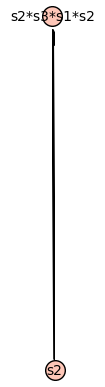

None


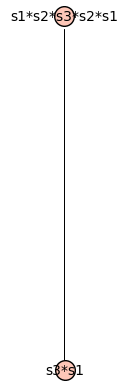

None
{s1, s3} {s1, s3}


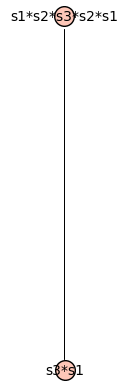

None


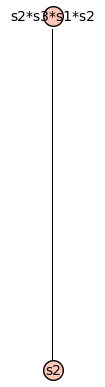

None


In [59]:
def W_subposet(L):
    '''This is equivalent to W.bruhat_poset().subposet(),
    but without calculating the full W.bruhat_poset().'''
    
    def br_le(x,y):
        return x.bruhat_le(y)    
    return Poset((L,br_le))

for dl in Subsets([s1,s2,s3]):
    for dr in Subsets([s1,s2,s3]):

        Pd = []
        Pa = []

        for x in W:
            if DL(x)==dl and DR(x)==dr:
                Pd.append(x)
            if AL(x)==dl and AR(x)==dr:
                Pa.append(x)

        if len(Pd)> 1 or len(Pa)> 1:
            Pd = W_subposet(Pd)
            Pa = W_subposet(Pa)
            
            print(dl,dr)
            
            print(Pd.show())
            print(Pa.show())

#            for x in Pd:
#                print(dic_[x] in Pa)

#            for x in Pa:
#                print(dic_[x] in Pd)

In [83]:
for w in W:
    wL = w0_([i for i in range(1,n+1) if convert_from_123(str(i)) not in  DL(w)])
    wR = w0_([i for i in range(1,n+1) if convert_from_123(str(i)) not in  DR(w)])
    print(convert_to_123(w), convert_to_123(dic_[w]),convert_to_123(wL*w*wR))

e 123121 e
3 121 12321
32 1231 23121
321 12312 321
2 31 12321
23 3121 12312
232 1 12321
2321 12 123121
21 1232 23121
231 312 123121
2312 12321 2312
23121 123 23121
1 232 12321
31 2 2312
312 231 123121
3121 23 123121
12 2321 12312
123 23121 123
1232 21 123121
12321 2312 12321
121 3 12321
1231 32 123121
12312 321 12312
123121 e 123121


In [85]:
for x in W:
    print(DL(x),DR(x))
    print(DL(x*w0),DR(x*w0))
    print()

set() set()
{s1, s3, s2} {s1, s3, s2}

{s3} {s3}
{s1, s2} {s3, s2}

{s3} {s2}
{s1, s2} {s1, s3}

{s3} {s1}
{s1, s2} {s1, s2}

{s2} {s2}
{s1, s3} {s1, s3}

{s2} {s3}
{s1, s3} {s3, s2}

{s3, s2} {s3, s2}
{s1} {s3}

{s3, s2} {s1, s3}
{s1} {s2}

{s2} {s1}
{s1, s3} {s1, s2}

{s2} {s1, s3}
{s1, s3} {s2}

{s2} {s2}
{s1, s3} {s1, s3}

{s3, s2} {s1, s2}
{s1} {s1}

{s1} {s1}
{s3, s2} {s1, s2}

{s1, s3} {s1, s3}
{s2} {s2}

{s1, s3} {s2}
{s2} {s1, s3}

{s1, s3} {s1, s2}
{s2} {s1}

{s1} {s2}
{s3, s2} {s1, s3}

{s1} {s3}
{s3, s2} {s3, s2}

{s1, s3} {s3, s2}
{s2} {s3}

{s1, s3} {s1, s3}
{s2} {s2}

{s1, s2} {s1, s2}
{s3} {s1}

{s1, s2} {s1, s3}
{s3} {s2}

{s1, s2} {s3, s2}
{s3} {s3}

{s1, s3, s2} {s1, s3, s2}
set() set()



[1, 2]

In [68]:
s1.reduced_word()[0]

1

In [70]:
w0_(s1.reduced_word())

s1